[-9.99999999e+19 -9.99999998e+19 -9.99999997e+19 ...  1.83054063e+20
  4.29195189e+20  4.46104812e+20]


Text(0, 0.5, 'Absolute Difference between ICESat-2 and CATS [m]')

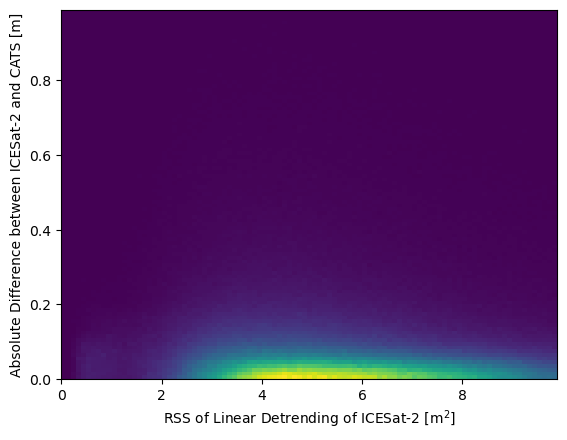

In [6]:
# Test netcdf loading
import xarray as xr
import numpy as np
from numpy.polynomial import Polynomial
import scipy
import cartopy.crs as ccrs
from pyproj import CRS, Transformer
import shapely
from shapely.geometry import Point, Polygon, shape
import shapefile
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

ds = xr.open_dataset("./polyfit_7_aug/ross_ATL11_tides.nc")

residuals = ds['detrend_residuals']
amp_diff = ds['amplitude'] - ds['amp_pyTMD']
m2_amp_diff = amp_diff.isel(constituent=0)

fig, ax = plt.subplots()
print(np.unique(m2_amp_diff))
ax.hist2d(residuals, np.abs(m2_amp_diff), bins=(np.arange(0, 10, 0.1), np.arange(0, 1, 0.01)))
ax.set_xlabel(r"RSS of Linear Detrending of ICESat-2 [m$^2$]")
ax.set_ylabel("Absolute Difference between ICESat-2 and CATS [m]")


[-9.99999999e+19 -9.99999998e+19 -9.99999997e+19 ...  1.83054063e+20
  4.29195189e+20  4.46104812e+20]


(0.0, 100.0)

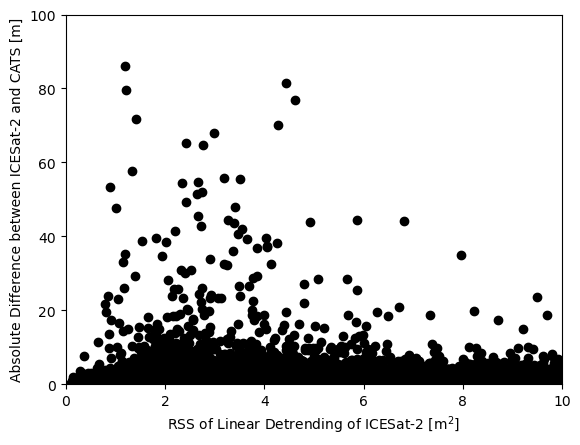

In [4]:
fig, ax = plt.subplots()
print(np.unique(m2_amp_diff))
ax.scatter(residuals, np.abs(m2_amp_diff),color='black')
ax.set_xlabel(r"RSS of Linear Detrending of ICESat-2 [m$^2$]")
ax.set_ylabel("Absolute Difference between ICESat-2 and CATS [m]")
ax.set_xlim(0,10)
ax.set_ylim(0,100)

In [7]:
len(np.unique(m2_amp_diff))
np.unique(m2_amp_diff)[2220000:]

array([1.00993373e+00, 1.00994354e+00, 1.00995818e+00, ...,
       1.83054063e+20, 4.29195189e+20, 4.46104812e+20])

In [8]:
def plot_shapefile(
    records: list[shapefile._Record],
    shapes: list[shapefile.Shape],
    ax ,
    colors: list[str],
    transform,
    fill: bool = False,
) -> None:
    """
    Plots the given records and shapes on axis ax.

    Parameters
    ----------
    records : list[shapefile._Record]
        Shapely record containing shape classification
    shapes : list[shapefile.Shape]
        Shapely shape points
    ax : cartopy.mpl.geoaxes.GeoAxes
        Axes to polot on
    colors : list[str]
    [Grounded ice color, Ice Shelf color]; Must be length 2
    """
    for record, shape in zip(records, shapes):
        classification = record[field_names.index("Id_text")]
        points = shape.points
        parts = list(shape.parts)
        parts.append(
            len(points)
        )  # Append the end index of the last part of the shapefile
        for i in range(len(parts) - 1):
            part = points[parts[i] : parts[i + 1]]
            if (
                classification == "Isolated island"
                or classification == "Ice rise or connected island"
                or classification == "Grounded ice or land"
            ):
                if fill:
                    ax.fill(*zip(*part), color=colors[0], zorder=2,transform=transform)
                else:
                    ax.plot(*zip(*part), color=colors[0], linewidth=1.5, zorder=2,transform=transform)
            elif classification == "Ice shelf":
                if fill:
                    ax.fill(*zip(*part), color=colors[1], zorder=2,transform=transform)
                else:
                    ax.plot(*zip(*part), color=colors[1], linewidth=1.5, zorder=2,transform=transform)
            else:
                print(f"Unknown classification: {classification}")

# Load ross polygon
ice_shelf_polygons = []
grounded_polygons = []
gl_path = '/Users/zachary_katz/Research/Antarctica_Masks/scripps_antarctica_polygons_v1.shp'
sf = shapefile.Reader(gl_path)
fields = sf.fields[1:] # Skip deletion flag
field_names = [field[0] for field in fields]
records = sf.records()
shapes = sf.shapes()

for record, shape in zip(records, shapes):
    classification = record[field_names.index("Id_text")]
    points = shape.points
    parts = list(shape.parts)
    parts.append(len(points))  # Append the end index of the last part
    for i in range(len(parts) - 1):
        part = points[parts[i]:parts[i + 1]]
        polygon = shapely.Polygon(part)
        if classification == "Isolated island" or classification == "Ice rise or connected island" or classification == "Grounded ice or land":
            if polygon.is_valid:
                grounded_polygons.append(polygon)
        elif classification == "Ice shelf":
            if polygon.is_valid:
                ice_shelf_polygons.append(polygon)
        else:
            print(f"Unknown classification: {classification}")


bbox = [-200000,-1800000,0,-800000] #Ross
# Filter records and shapes to bbox
filtered_records = []
filtered_shapes = []
for record, shape in zip(records, shapes):
    shape_bbox = shape.bbox
    # Checks if any part of the shape is within the bounding box
    classification = record[field_names.index("Id_text")]
    if (
        shape_bbox[0] < bbox[2]
        and shape_bbox[2] > bbox[0]
        and shape_bbox[1] < bbox[3]
        and shape_bbox[3] > bbox[1]
    ) and  classification == "Ice shelf":
        filtered_records.append(record)
        filtered_shapes.append(shape)

In [16]:
# Set mask to try and plot...

#mask = [sum(pd.notna(times)) > 16 for times in ds['datetime'].values[:]]
mask = ds['amplitude'].isel(constituent=0) < 0.25
mask = ds['detrend_residuals'] < 6

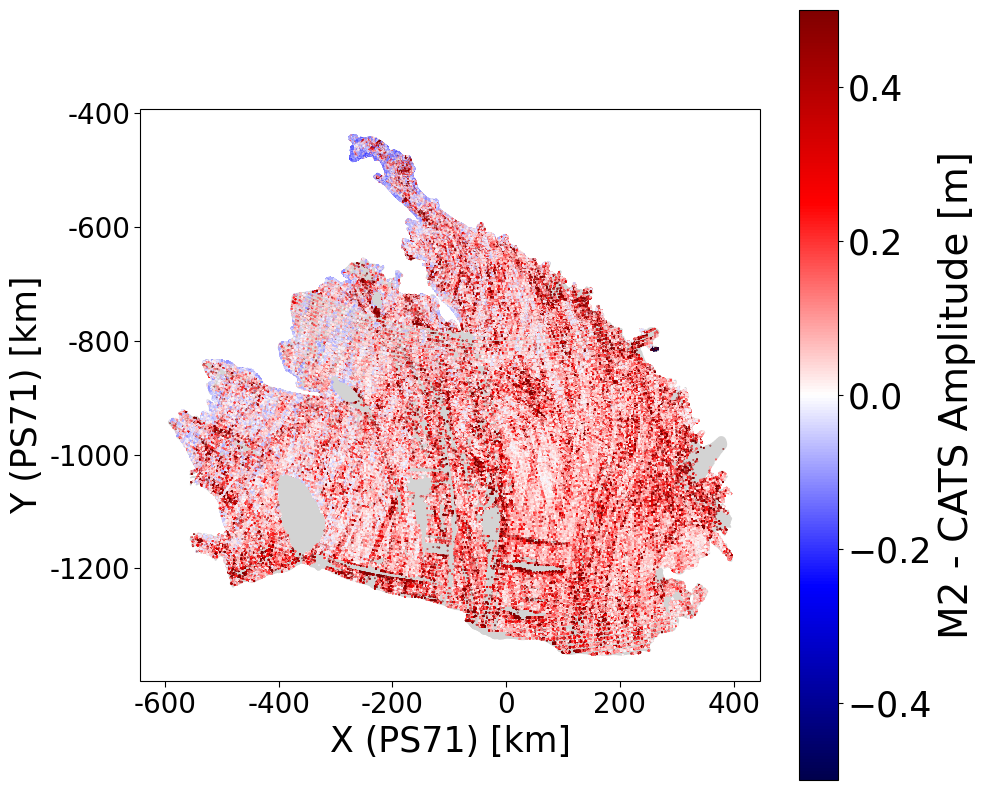

In [17]:
# Plot some more stats
hmin = -0.5
hmax = 0.5
for i in range(1): # Loop over amplitudes
    ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
    fig, ax = plt.subplots(
        figsize=(10, 10),
        subplot_kw={'projection': ps71_projection},
    )
    plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "lightgray"], ps71_projection, fill=True)


    col = ax.scatter(ds['x'][mask], ds['y'][mask], s=0.1, zorder=10, c=m2_amp_diff[mask], cmap='seismic',vmin=hmin,vmax=hmax)
    cbar = fig.colorbar(col)

    KM_SCALE = 1e3
    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_xlabel("X (PS71) [km]", size=25)
    ax.set_ylabel("Y (PS71) [km]", size=25)
    ax.tick_params(labelsize=20)
    ax.tick_params(size=4)

    cbar.ax.tick_params(labelsize=25)
    cbar.set_label("M2 - CATS Amplitude [m]", fontsize=28, color="black")

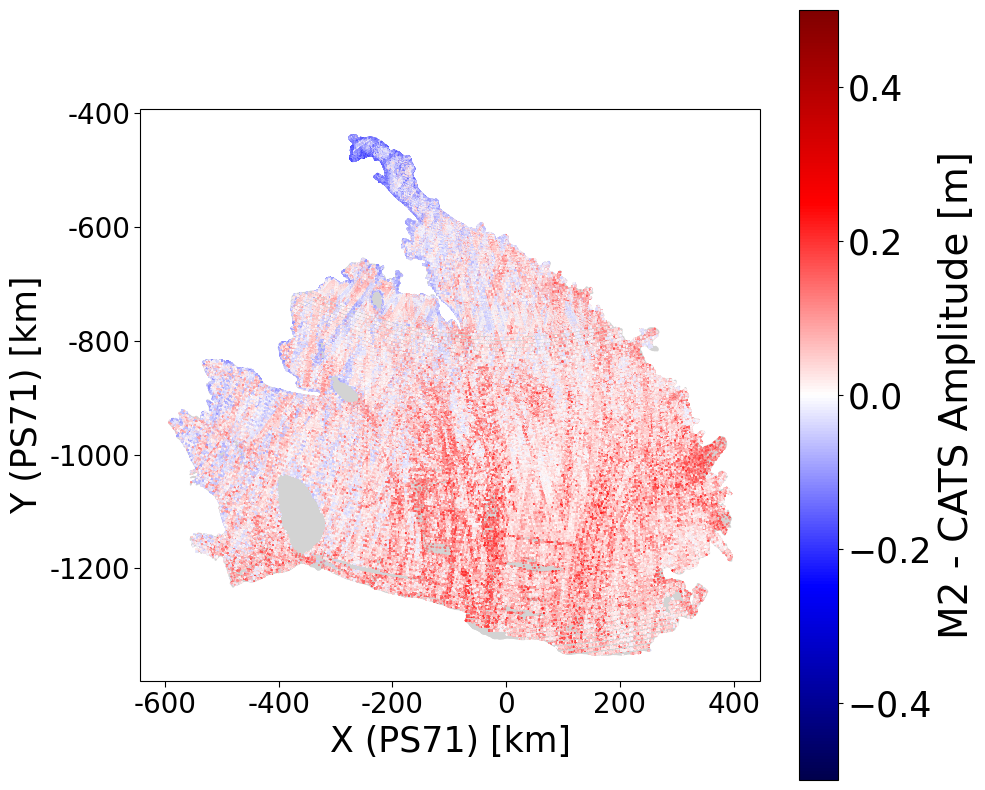

In [7]:
# Plot filtered data
hmin = -0.5
hmax = 0.5
for i in range(1): # Loop over amplitudes
    ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
    fig, ax = plt.subplots(
        figsize=(10, 10),
        subplot_kw={'projection': ps71_projection},
    )
    plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "lightgray"], ps71_projection, fill=True)


    col = ax.scatter(ds['x'][mask], ds['y'][mask], s=0.1, zorder=10, c=m2_amp_diff[mask], cmap='seismic',vmin=hmin,vmax=hmax)
    cbar = fig.colorbar(col)

    KM_SCALE = 1e3
    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_xlabel("X (PS71) [km]", size=25)
    ax.set_ylabel("Y (PS71) [km]", size=25)
    ax.tick_params(labelsize=20)
    ax.tick_params(size=4)

    cbar.ax.tick_params(labelsize=25)
    cbar.set_label("M2 - CATS Amplitude [m]", fontsize=28, color="black")

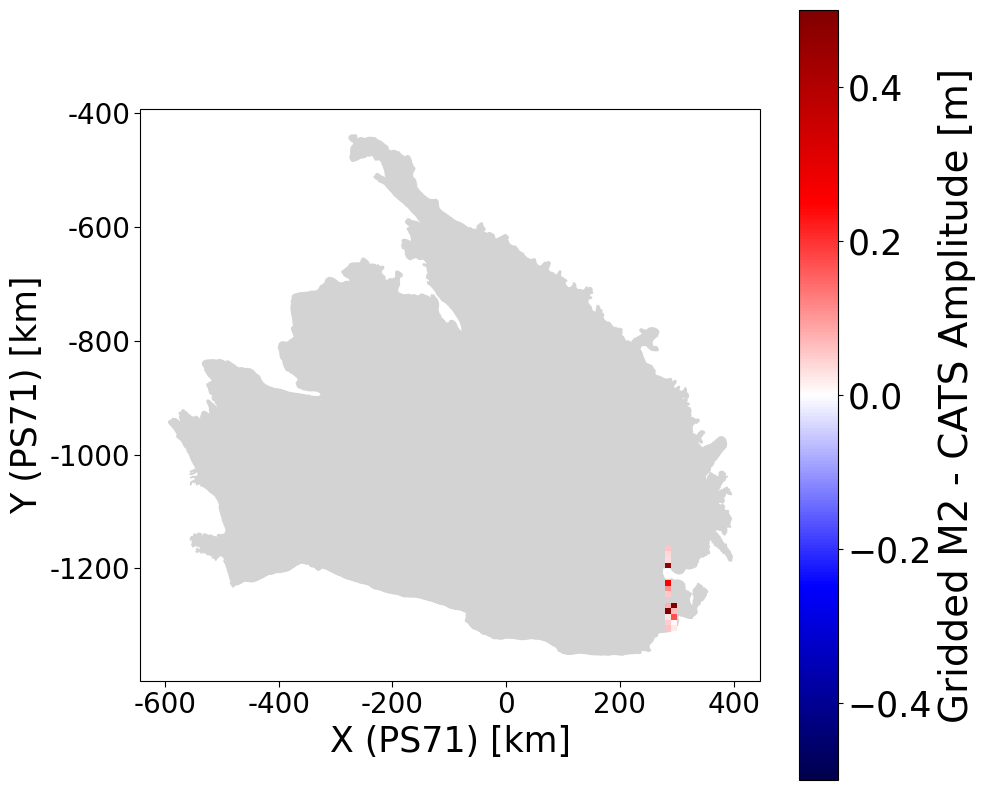

In [4]:
# Grid resulting netcdf into averaged chunks
hmin = -0.5
hmax = 0.5

def gaussian_smooth_to_grid(x, y, values, x_grid, y_grid, sigma=10000, cutoff=3):
    """
    Vectorized Gaussian smoothing from scattered points to a regular grid.
    sigma and cutoff in meters.
    """
    Xg, Yg = np.meshgrid(x_grid, y_grid)
    Zg = np.full(Xg.shape, np.nan, dtype=float)

    coords = np.column_stack((x, y))
    sigma2 = sigma**2
    cutoff_dist2 = (cutoff * sigma)**2

    # Flatten grid for easier vectorized math
    grid_points = np.column_stack((Xg.ravel(), Yg.ravel()))

    # Chunk through grid points to limit memory usage
    chunk_size = 5000
    for start in range(0, len(grid_points), chunk_size):
        end = start + chunk_size
        gp_chunk = grid_points[start:end]  # (n_chunk, 2)

        # Compute squared distances to all data points (broadcasted)
        dx = gp_chunk[:, None, 0] - x[None, :]
        dy = gp_chunk[:, None, 1] - y[None, :]
        dist2 = dx**2 + dy**2

        # Mask beyond cutoff distance
        mask = dist2 <= cutoff_dist2
        weights = np.exp(-0.5 * dist2 / sigma2) * mask

        # Weighted mean for each grid point
        weighted_sum = np.sum(weights * values[None, :], axis=1)
        sum_weights = np.sum(weights, axis=1)
        smoothed_vals = np.divide(weighted_sum, sum_weights, where=sum_weights > 0)

        # Store results back into Zg
        Zg.ravel()[start:end] = smoothed_vals

    return Zg

for i in range(1): # Loop over amplitudes
    ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
    fig, ax = plt.subplots(
        figsize=(10, 10),
        subplot_kw={'projection': ps71_projection},
    )
    plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "lightgray"], ps71_projection, fill=True)
    x_grid = np.arange(np.min(ds['x']), np.max(ds['x']) + 10000, 10000)
    y_grid = np.arange(np.min(ds['y']), np.max(ds['y']) + 10000, 10000)

    Z_smooth = gaussian_smooth_to_grid(
        np.asarray(ds['x']),
        np.asarray(ds['y']),
        np.asarray(m2_amp_diff),
        x_grid,
        y_grid,
        sigma=10000,
    )

    col = ax.pcolormesh(x_grid, y_grid, Z_smooth, cmap='seismic', zorder=10, vmin=hmin, vmax=hmax)
    #col = ax.scatter(ds['x'], ds['y'], s=0.1, zorder=10, c=m2_amp_diff, cmap='seismic',vmin=hmin,vmax=hmax)
    cbar = fig.colorbar(col)

    KM_SCALE = 1e3
    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_xlabel("X (PS71) [km]", size=25)
    ax.set_ylabel("Y (PS71) [km]", size=25)
    ax.tick_params(labelsize=20)
    ax.tick_params(size=4)

    cbar.ax.tick_params(labelsize=25)
    cbar.set_label("Gridded M2 - CATS Amplitude [m]", fontsize=28, color="black")

In [60]:
# Smooth instead of gridding?
# FROM CHATGPT
def gaussian_smooth_to_grid(x, y, values, x_grid, y_grid, sigma=10000, cutoff=3):
    """
    Vectorized Gaussian smoothing from scattered points to a regular grid.
    sigma and cutoff in meters.
    """
    Xg, Yg = np.meshgrid(x_grid, y_grid)
    Zg = np.full(Xg.shape, np.nan, dtype=float)

    coords = np.column_stack((x, y))
    sigma2 = sigma**2
    cutoff_dist2 = (cutoff * sigma)**2

    # Flatten grid for easier vectorized math
    grid_points = np.column_stack((Xg.ravel(), Yg.ravel()))

    # Chunk through grid points to limit memory usage
    chunk_size = 5000
    for start in range(0, len(grid_points), chunk_size):
        end = start + chunk_size
        gp_chunk = grid_points[start:end]  # (n_chunk, 2)

        # Compute squared distances to all data points (broadcasted)
        dx = gp_chunk[:, None, 0] - x[None, :]
        dy = gp_chunk[:, None, 1] - y[None, :]
        dist2 = dx**2 + dy**2

        # Mask beyond cutoff distance
        mask = dist2 <= cutoff_dist2
        weights = np.exp(-0.5 * dist2 / sigma2) * mask

        # Weighted mean for each grid point
        weighted_sum = np.sum(weights * values[None, :], axis=1)
        sum_weights = np.sum(weights, axis=1)
        smoothed_vals = np.divide(weighted_sum, sum_weights, where=sum_weights > 0)

        # Store results back into Zg
        Zg.ravel()[start:end] = smoothed_vals

    return Zg


hmin = -0.5
hmax = 0.5
for i in range(1): # Loop over amplitudes
    ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
    fig, ax = plt.subplots(
        figsize=(10, 10),
        subplot_kw={'projection': ps71_projection},
    )
    plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "lightgray"], ps71_projection, fill=True)
    x_grid = np.arange(np.min(ds['x']), np.max(ds['x']) + 10000, 10000)
    y_grid = np.arange(np.min(ds['y']), np.max(ds['y']) + 10000, 10000)

    Z_smooth = gaussian_smooth_to_grid(
        np.asarray(ds['x']),
        np.asarray(ds['y']),
        np.asarray(m2_amp_diff),
        x_grid,
        y_grid,
        sigma=10000,
    )

    col = ax.pcolormesh(x_grid, y_grid, Z_smooth, cmap='seismic', zorder=10, vmin=hmin, vmax=hmax)
    #col = ax.scatter(ds['x'], ds['y'], s=0.1, zorder=10, c=m2_amp_diff, cmap='seismic',vmin=hmin,vmax=hmax)
    cbar = fig.colorbar(col)

    KM_SCALE = 1e3
    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_xlabel("X (PS71) [km]", size=25)
    ax.set_ylabel("Y (PS71) [km]", size=25)
    ax.tick_params(labelsize=20)
    ax.tick_params(size=4)

    cbar.ax.tick_params(labelsize=25)
    cbar.set_label("Gaussian M2 - CATS Amplitude [m]", fontsize=28, color="black")


: 

In [10]:
# Test np.concatentae

import numpy as np

a = [[1,1,1],[5,5,5]]
b = [[4,4,4],[10,10,2]]

s = []
for x, y in zip(a,b):
    print(x,y)
    g = np.concatenate((x,y))
    print(g)
    s.append(g)
print(s)

[1, 1, 1] [4, 4, 4]
[1 1 1 4 4 4]
[5, 5, 5] [10, 10, 2]
[ 5  5  5 10 10  2]
[array([1, 1, 1, 4, 4, 4]), array([ 5,  5,  5, 10, 10,  2])]


[ 0.11 -0.14 -0.04  0.06  0.01]
[0. 1. 2. 3. 4.] [ 0.11 -0.14 -0.04  0.06  0.01]
[0.037]


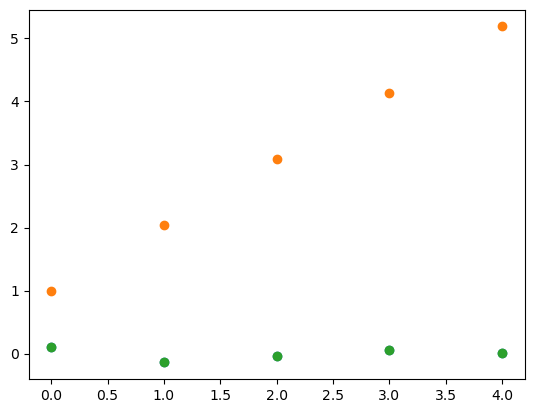

In [45]:
# Test np.polynomial

from numpy.polynomial import Polynomial
import scipy


x = np.linspace(0, 4, 5)
y = np.array([1.1,1.9,3.05,4.2,5.2])

poly, stats = Polynomial.fit(x,y,1,full=True)
fitted_y = poly(np.array(x))

y_scipy = scipy.signal.detrend(y, type='linear')
print(y_scipy)
print(x,y-fitted_y) # detrended y values
print(stats[0]) # Residual

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x,y-fitted_y)
ax.scatter(x,fitted_y)
ax.scatter(x,y_scipy)


Residuals from scipy.signal.detrend: [ 0.11 -0.14 -0.04  0.06  0.01]
Residuals from Polynomial.fit: [0.10999999999999943 -0.14000000000000057 -- 0.05999999999999961
 0.010000000000000675]


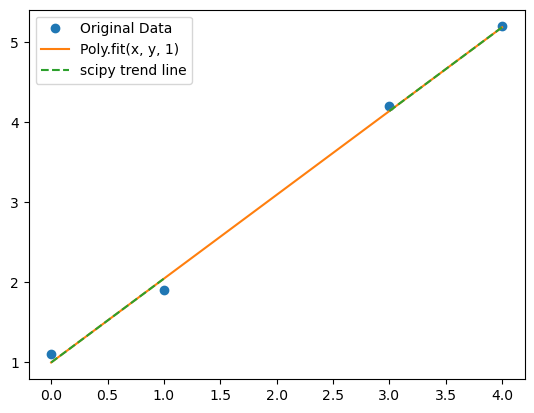

In [47]:
import numpy as np
from scipy.signal import detrend
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt

# Uniformly spaced x
x = np.linspace(0, 4, 5)
y = np.ma.array([1.1,1.9,3.05,4.2,5.2],mask=[0, 0, 1, 0, 0])

# Scipy detrend (removes linear trend based on indices)
resid_scipy = detrend(y, type='linear')

# Polynomial fit
p, _ = Polynomial.fit(x, y, 1, full=True)
fitted_y = p(x)
resid_poly = y - fitted_y

# Print comparison
print("Residuals from scipy.signal.detrend:", resid_scipy)
print("Residuals from Polynomial.fit:", resid_poly)

# Visualize
plt.plot(x, y, 'o', label='Original Data')
plt.plot(x, fitted_y, '-', label='Poly.fit(x, y, 1)')
plt.plot(x, y - resid_scipy, '--', label='scipy trend line')
plt.legend()
plt.show()

In [1]:

# Zachary Katz
# zachary_katz@mines.edu
# 04 June 2025

"""

Download ATL 11 granule if necessary
Extract example with multiple crossing tracks
"""

# Imports
import earthaccess
from pathlib import Path
import h5py
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from shapely.geometry import Point, Polygon, shape
import shapefile
import cartopy.crs as ccrs
from pyproj import CRS, Transformer
import re
from itertools import combinations

# User-defined path
data_path = './_data/ATL11'
gl_path = '/Users/zachary_katz/Research/Antarctica_Masks/scripps_antarctica_polygons_v1.shp'


In [2]:
auth = earthaccess.login()

In [3]:
# Earthaccess unable to handle crossing 180 deg so download in two chunks
short_name = 'ATL11'
bbox_west = (-180,-86, -140,-75)
bbox_east = (155,-86,180, -75)

st = '2021-01-01'
ed = '2025-06-01'
# Download ATL11 if necessary
results = earthaccess.search_data(short_name = 'ATL11', 
bounding_box = bbox_east)
temporal = (st,ed)
print(len(results))
earthaccess.download(results, data_path, provider='POCLOUD')

results = earthaccess.search_data(short_name = 'ATL11', 
bounding_box = bbox_west)
temporal = (st,ed)
print(len(results))
earthaccess.download(results, data_path, provider='POCLOUD')

1138


QUEUEING TASKS | :   0%|          | 0/1138 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1138 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1138 [00:00<?, ?it/s]

1600


QUEUEING TASKS | :   0%|          | 0/1600 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1600 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1600 [00:00<?, ?it/s]

['_data/ATL11/ATL11_000711_0326_006_12.h5',
 '_data/ATL11/ATL11_000712_0326_006_12.h5',
 '_data/ATL11/ATL11_000811_0326_006_12.h5',
 '_data/ATL11/ATL11_000812_0326_006_12.h5',
 '_data/ATL11/ATL11_000911_0326_006_12.h5',
 '_data/ATL11/ATL11_001311_0326_006_12.h5',
 '_data/ATL11/ATL11_001410_0326_006_12.h5',
 '_data/ATL11/ATL11_001411_0326_006_12.h5',
 '_data/ATL11/ATL11_001510_0326_006_12.h5',
 '_data/ATL11/ATL11_001511_0326_006_12.h5',
 '_data/ATL11/ATL11_002211_0326_006_12.h5',
 '_data/ATL11/ATL11_002212_0326_006_12.h5',
 '_data/ATL11/ATL11_002311_0326_006_12.h5',
 '_data/ATL11/ATL11_002312_0326_006_12.h5',
 '_data/ATL11/ATL11_002411_0326_006_12.h5',
 '_data/ATL11/ATL11_002811_0326_006_12.h5',
 '_data/ATL11/ATL11_002910_0326_006_12.h5',
 '_data/ATL11/ATL11_002911_0326_006_12.h5',
 '_data/ATL11/ATL11_003010_0326_006_12.h5',
 '_data/ATL11/ATL11_003011_0326_006_12.h5',
 '_data/ATL11/ATL11_003712_0326_006_12.h5',
 '_data/ATL11/ATL11_003811_0326_006_12.h5',
 '_data/ATL11/ATL11_003812_0326_

In [4]:
files = list(Path(data_path).glob('*.h5'))

In [2]:
def plot_shapefile(
    records: list[shapefile._Record],
    shapes: list[shapefile.Shape],
    ax ,
    colors: list[str],
    transform,
    fill: bool = False,
) -> None:
    """
    Plots the given records and shapes on axis ax.

    Parameters
    ----------
    records : list[shapefile._Record]
        Shapely record containing shape classification
    shapes : list[shapefile.Shape]
        Shapely shape points
    ax : cartopy.mpl.geoaxes.GeoAxes
        Axes to polot on
    colors : list[str]
       [Grounded ice color, Ice Shelf color]; Must be length 2
    """
    for record, shape in zip(records, shapes):
        classification = record[field_names.index("Id_text")]
        points = shape.points
        parts = list(shape.parts)
        parts.append(
            len(points)
        )  # Append the end index of the last part of the shapefile
        for i in range(len(parts) - 1):
            part = points[parts[i] : parts[i + 1]]
            if (
                classification == "Isolated island"
                or classification == "Ice rise or connected island"
                or classification == "Grounded ice or land"
            ):
                if fill:
                    ax.fill(*zip(*part), color=colors[0], zorder=2,transform=transform)
                else:
                    ax.plot(*zip(*part), color=colors[0], linewidth=1.5, zorder=2,transform=transform)
            elif classification == "Ice shelf":
                if fill:
                    ax.fill(*zip(*part), color=colors[1], zorder=2,transform=transform)
                else:
                    ax.plot(*zip(*part), color=colors[1], linewidth=1.5, zorder=2,transform=transform)
            else:
                print(f"Unknown classification: {classification}")

In [3]:
# Load ross polygon
ice_shelf_polygons = []
grounded_polygons = []

sf = shapefile.Reader(gl_path)
fields = sf.fields[1:] # Skip deletion flag
field_names = [field[0] for field in fields]
records = sf.records()
shapes = sf.shapes()

for record, shape in zip(records, shapes):
    classification = record[field_names.index("Id_text")]
    points = shape.points
    parts = list(shape.parts)
    parts.append(len(points))  # Append the end index of the last part
    for i in range(len(parts) - 1):
        part = points[parts[i]:parts[i + 1]]
        polygon = shapely.Polygon(part)
        if classification == "Isolated island" or classification == "Ice rise or connected island" or classification == "Grounded ice or land":
            if polygon.is_valid:
                grounded_polygons.append(polygon)
        elif classification == "Ice shelf":
            if polygon.is_valid:
                ice_shelf_polygons.append(polygon)
        else:
            print(f"Unknown classification: {classification}")


bbox = [-200000,-1800000,0,-800000] #Ross
# Filter records and shapes to bbox
filtered_records = []
filtered_shapes = []
for record, shape in zip(records, shapes):
    shape_bbox = shape.bbox
    # Checks if any part of the shape is within the bounding box
    classification = record[field_names.index("Id_text")]
    if (
        shape_bbox[0] < bbox[2]
        and shape_bbox[2] > bbox[0]
        and shape_bbox[1] < bbox[3]
        and shape_bbox[3] > bbox[1]
    ) and  classification == "Ice shelf":
        filtered_records.append(record)
        filtered_shapes.append(shape)

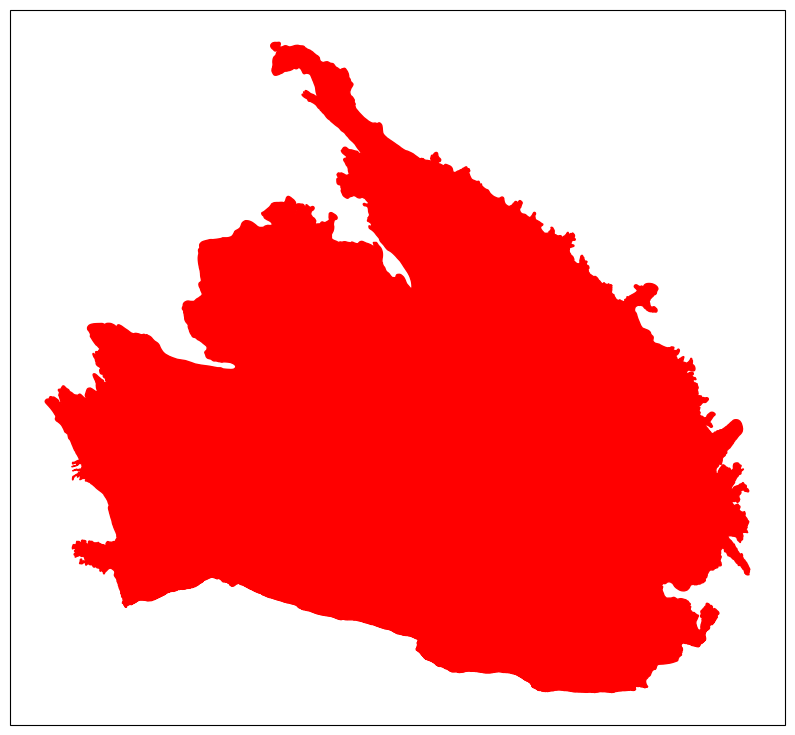

In [4]:
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ps71_projection},
)
plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "red"], ps71_projection, fill=True)

In [5]:
def ll2xy(lon: list[float], lat: list[float]) -> tuple[list[float], list[float]]:
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y).
    Can also take single floats.

    Parameters
    ----------
    lon: list[float]
         Geodetic longitude in EPSG:4326
    lat: list[float]
         Geodetic latitude in EPSG:4326

    Returns
    -------
    x: list[float]
       Antarctic Polar Stereographic (EPSG:3031) x
    y: list[float]
       Antarctic Polar Stereographic (EPSG:3031) y
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

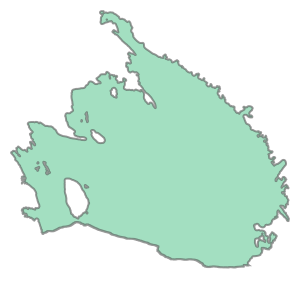

In [6]:
from shapely.geometry import Point, Polygon, shape
ross = shape(filtered_shapes[0].__geo_interface__)
ross

In [9]:
### STREAMLINE EVERYTHING BELOW IN 20 FILE CHUNKS ###

# Each reference track pair is a group
group = ['/pt1/','/pt2/','/pt3/']

chunk_size = 20
num_chunks = (len(files) + chunk_size - 1) // chunk_size  

csv_index = 0
for chunk_idx in range(num_chunks):
    start_idx = chunk_idx * chunk_size
    end_idx = min(start_idx + chunk_size, len(files))
    file_chunk = files[start_idx:end_idx]

    print(f"Processing chunk {chunk_idx+1}/{num_chunks} with {len(file_chunk)} files...")

    # Make array of ATL11 data
    print("ATL11 Data Array")
    data_arr = []
    # Loop over files
    for file in file_chunk:
        # Loop over pairs
        for i, g in enumerate(group):
            data = {}
            # Load variables into dictionary list
            with h5py.File(file, 'r') as fi:

                data['t_ref'] = fi['/ancillary_data/atlas_sdp_gps_epoch'][:] # ICESat-2 reference epoch
                data['filename'] = file
                data['group'] = g
            
                # Crossing track data
                data['x_q_flag'] = fi[g+'crossing_track_data/atl06_quality_summary'][:] #0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
                data['x_lat'] = fi[g+'crossing_track_data/latitude'][:] # Latitude [degrees]
                data['x_lon'] = fi[g+'crossing_track_data/longitude'][:] # Longitude [degrees]
                data['x_h_corr'] = fi[g+'crossing_track_data/h_corr'][:] # Mean corrected height [m]
                data['x_t_dt'] = fi[g+'crossing_track_data/delta_time'][:] # GPS seconds since reference epoch
                data['x_cycle_number'] = fi[g+'crossing_track_data/cycle_number'][:] # Cycle
                data['x_rgt'] = fi[g+'crossing_track_data/rgt'][:] # Reference ground track
                data['x_spot_crossing'] = fi[g+'crossing_track_data/spot_crossing'][:] # Spot  number
                data['x_ref_pt'] = fi[g+'crossing_track_data/ref_pt'][:] # Reference point
                data['x_x'], data['x_y'] = ll2xy(data['x_lon'],data['x_lat'])


                time_temp = data['t_ref'] + data['x_t_dt']
                data['x_time'] = Time(time_temp, format='gps').iso # Convert to readable time
                
                # Main track data
                data['lat'] = fi[g+'/latitude'][:] # Latitude [degrees]
                data['lon'] = fi[g+'/longitude'][:] # Longitude [degrees]
                data['h_corr'] = fi[g+'/h_corr'][:] # Mean corrected height [m]
                data['t_dt'] = fi[g+'/delta_time'][:] # GPS seconds since reference epoch
                data['q_flag'] = fi[g+'/quality_summary'][:] #0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
                data['cycle_number'] = fi[g+'/cycle_number'][:] # Cycle
                data['ref_pt'] = fi[g+'/ref_pt'][:] # Reference point
                time_temp = data['t_ref'] + data['t_dt']
                data['time'] = Time(time_temp, format='gps').iso # Convert to readable time

                data['x'], data['y'] = ll2xy(data['lon'],data['lat'])
                
            data_arr.append(data)

    print("Downscaling to Ross Ice Shelf")
    # Downscale data so only in ross polygon
    for data in data_arr[:]:
        inside_mask = []
        x_inside_mask = []
        for xi, yi in zip(data['x'], data['y']):
            point = Point(xi, yi)
            inside_mask.append(ross.contains(point))
        data['inside_mask'] = inside_mask

        for xi, yi in zip(data['x_x'], data['x_y']):
            point = Point(xi, yi)
            x_inside_mask.append(ross.contains(point))

        data['x_inside_mask'] = x_inside_mask

    print("Creating Crossover Table")
    # Loop over each track and create crossover table
    dfs = []
    for data in data_arr[:]:
        i = 0
        for ref_pt in data['ref_pt'][data['inside_mask']]:

            mskx = (data['x_ref_pt'] == ref_pt) & (data['x_t_dt'] < 2e300)
            msk = (data['ref_pt'] == ref_pt)
            mskd_lat = data['lat'][msk]
            mskd_lon = data['lon'][msk]
            mskd_xlat = data['x_lat'][mskx]
            mskd_xlon = data['x_lon'][mskx]
            mskd_xt = data['x_time'][mskx]
            mskd_xcycle = data['x_cycle_number'][mskx]
            mskd_xrgt = data['x_rgt'][mskx]

            mskd_t = data['time'][msk]
            mskd_tdt = data['t_dt'][msk]
            msk_t = mskd_tdt < 2e300
            mskd_t = mskd_t[msk_t]

            mskd_h = data['h_corr'][msk]
            mskd_h = mskd_h[msk_t]
            mskd_xh = data['x_h_corr'][mskx]
            
            mskd_q = data['q_flag'][msk]
            mskd_q = mskd_q[msk_t]
            mskd_xq = data['x_q_flag'][mskx]

            msk_t = msk_t.flatten()
            mskd_cycle = data['cycle_number'][msk_t]

            mskd_lon = np.ones(len(mskd_t)) * mskd_lon
            mskd_lat = np.ones(len(mskd_t)) * mskd_lat

            match = re.search(r'ATL11_(\d{4})', str(data['filename']))
            mskd_rgt = np.ones(len(mskd_t),dtype=int) * int(match.group(1))
            
            #print(len(mskd_xlat),len(mskd_xlon),len(mskd_xt),len(mskd_xcycle),len(mskd_xh))
            #print(len(mskd_lat),len(mskd_lon),len(mskd_t),len(mskd_cycle),len(mskd_h[0]))
            if len(mskd_xlat) > 5:
                df1 = pd.DataFrame(
                {
                    'lat': mskd_xlat,
                    'lon': mskd_xlon,
                    'time': mskd_xt,
                    'height': mskd_xh,
                    'q_flag': mskd_xq,
                    'cycle_number': mskd_xcycle,
                    'rgt': mskd_xrgt
                }
                )
                df2 = pd.DataFrame(
                    {
                        'lat': mskd_lat,
                        'lon': mskd_lon,
                        'time': mskd_t,
                        'height': mskd_h,
                        'q_flag': mskd_q,
                        'cycle_number': mskd_cycle,
                        'rgt': mskd_rgt
                    }
                )
                df = pd.concat([df1,df2], ignore_index=True)
                df = df.sort_values(by=['time']).reset_index(drop=True);
                dfs.append(df)

    print("Generate all Combinations at each point")
    # Generate all combos for laurie
    combined_rows = []
    for iter, df in enumerate(dfs[:]):
        #print(iter)
        # Iterate over all unique pairs of rows
        rows = df.reset_index()
        
        lat_arr = rows['lat'].values
        lon_arr = rows['lon'].values
        time_arr = rows['time'].values
        height_arr = rows['height'].values
        q_flag_arr = rows['q_flag'].values
        cycle_arr = rows['cycle_number'].values
        rgt_arr = rows['rgt'].values

        pairs = list(combinations(range(len(rows)), 2))

        # Prepare list to store new rows
        for i, j in pairs:
            new_row = [
                lat_arr[i],
                lon_arr[i],
                time_arr[i],
                time_arr[j],
                height_arr[i],
                height_arr[j],
                q_flag_arr[i],
                q_flag_arr[j],
                cycle_arr[i],
                cycle_arr[j],
                rgt_arr[i],
                rgt_arr[j]
            ]
            combined_rows.append(new_row)

        columns = [
        'lat', 'lon', 'time_1', 'time_2', 'height_1', 'height_2',
        'quality_1', 'quality_2', 'cycle_1', 'cycle_2', 'rgt_1', 'rgt_2'
    ]

    print("Make into large dataframe")
    laurie_df = pd.DataFrame(combined_rows[:], columns=columns)

    print("Saving Dataframe")
    laurie_df.to_csv(f"Ross_ATL11Crossovers_{csv_index}", index=False)
    csv_index += 1

Processing chunk 1/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 2/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 3/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 4/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 5/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 6/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 7/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 8/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 9/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 10/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 11/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 12/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 13/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 14/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 15/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 16/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 17/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 18/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 19/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 20/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 21/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 22/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 23/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 24/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 25/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 26/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 27/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 28/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 29/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 30/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 31/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 32/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 33/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 34/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 35/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 36/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 37/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 38/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 39/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 40/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 41/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 42/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 43/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 44/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 45/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 46/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 47/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 48/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 49/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 50/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 51/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 52/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 53/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 54/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 55/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 56/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 57/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 58/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 59/60 with 20 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 60/60 with 13 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe


In [ ]:
# SAME AS ABOVE, BUT AS INDIVIDUAL CELLS#

# Make array of ATL11 data
data_arr = []

# Each reference track pair is a group
group = ['/pt1/','/pt2/','/pt3/']

# Loop over files
for file in files[:12]:
    # Loop over pairs
    for i, g in enumerate(group):
        data = {}
        # Load variables into dictionary list
        with h5py.File(file, 'r') as fi:


            data['t_ref'] = fi['/ancillary_data/atlas_sdp_gps_epoch'][:] # ICESat-2 reference epoch
            data['filename'] = file
            data['group'] = g
           
            # Crossing track data
            data['x_q_flag'] = fi[g+'crossing_track_data/atl06_quality_summary'][:] #0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
            data['x_lat'] = fi[g+'crossing_track_data/latitude'][:] # Latitude [degrees]
            data['x_lon'] = fi[g+'crossing_track_data/longitude'][:] # Longitude [degrees]
            data['x_h_corr'] = fi[g+'crossing_track_data/h_corr'][:] # Mean corrected height [m]
            data['x_t_dt'] = fi[g+'crossing_track_data/delta_time'][:] # GPS seconds since reference epoch
            data['x_cycle_number'] = fi[g+'crossing_track_data/cycle_number'][:] # Cycle
            data['x_rgt'] = fi[g+'crossing_track_data/rgt'][:] # Reference ground track
            data['x_spot_crossing'] = fi[g+'crossing_track_data/spot_crossing'][:] # Spot  number
            data['x_ref_pt'] = fi[g+'crossing_track_data/ref_pt'][:] # Reference point
            data['x_x'], data['x_y'] = ll2xy(data['x_lon'],data['x_lat'])


            time_temp = data['t_ref'] + data['x_t_dt']
            data['x_time'] = Time(time_temp, format='gps').iso # Convert to readable time
            
            # Main track data
            data['lat'] = fi[g+'/latitude'][:] # Latitude [degrees]
            data['lon'] = fi[g+'/longitude'][:] # Longitude [degrees]
            data['h_corr'] = fi[g+'/h_corr'][:] # Mean corrected height [m]
            data['t_dt'] = fi[g+'/delta_time'][:] # GPS seconds since reference epoch
            data['q_flag'] = fi[g+'/quality_summary'][:] #0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
            data['cycle_number'] = fi[g+'/cycle_number'][:] # Cycle
            data['ref_pt'] = fi[g+'/ref_pt'][:] # Reference point
            time_temp = data['t_ref'] + data['t_dt']
            data['time'] = Time(time_temp, format='gps').iso # Convert to readable time

            data['x'], data['y'] = ll2xy(data['lon'],data['lat'])
            
        data_arr.append(data)

/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

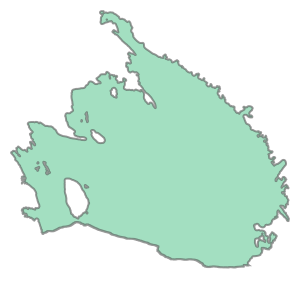

In [9]:
from shapely.geometry import Point, Polygon, shape
ross = shape(filtered_shapes[0].__geo_interface__)
ross

In [10]:
# Downscale data so only in ross polygon
for data in data_arr[:]:
    inside_mask = []
    x_inside_mask = []
    for xi, yi in zip(data['x'], data['y']):
        point = Point(xi, yi)
        inside_mask.append(ross.contains(point))
    data['inside_mask'] = inside_mask

    for xi, yi in zip(data['x_x'], data['x_y']):
        point = Point(xi, yi)
        x_inside_mask.append(ross.contains(point))

    data['x_inside_mask'] = x_inside_mask

285336.9140252916 -1292835.4459196785


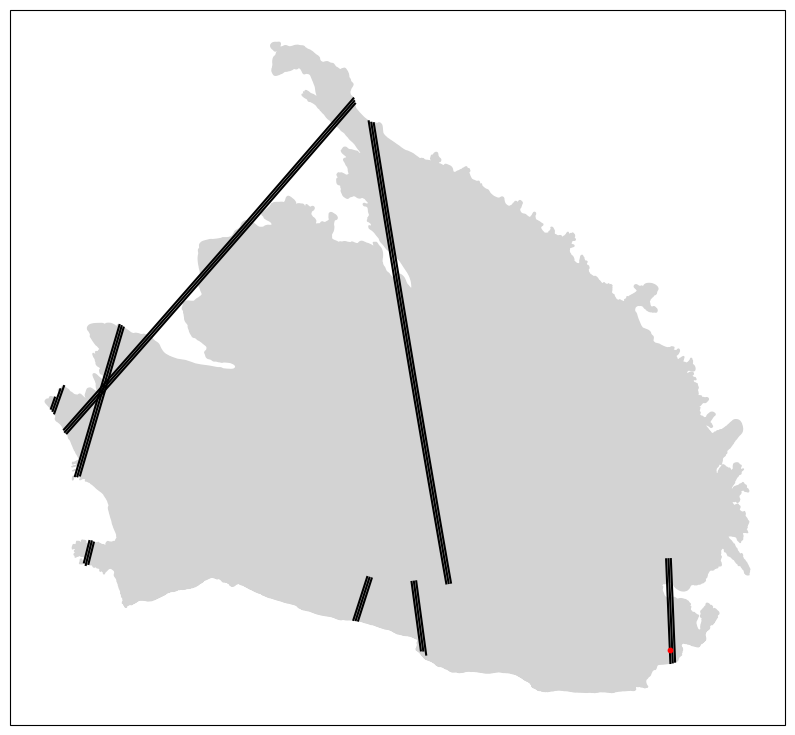

In [11]:
# Plot points in mask as sanity check
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ps71_projection},
)
plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "lightgray"], ps71_projection, fill=True)
for data in data_arr:
    ax.plot(data['x'][data['inside_mask']],data['y'][data['inside_mask']],color='black')

x,y = ll2xy(167.553988,-77.858628,)
print(x,y)
ax.scatter(x,y,color='red',s=10,zorder=10)

In [63]:
# Loop over each track and create crossover table
dfs = []
for data in data_arr[:]:
    i = 0
    for ref_pt in data['ref_pt'][data['inside_mask']]:

        mskx = (data['x_ref_pt'] == ref_pt) & (data['x_t_dt'] < 2e300)
        msk = (data['ref_pt'] == ref_pt)
        mskd_lat = data['lat'][msk]
        mskd_lon = data['lon'][msk]
        mskd_xlat = data['x_lat'][mskx]
        mskd_xlon = data['x_lon'][mskx]
        mskd_xt = data['x_time'][mskx]
        mskd_xcycle = data['x_cycle_number'][mskx]
        mskd_xrgt = data['x_rgt'][mskx]

        mskd_t = data['time'][msk]
        mskd_tdt = data['t_dt'][msk]
        msk_t = mskd_tdt < 2e300
        mskd_t = mskd_t[msk_t]

        mskd_h = data['h_corr'][msk]
        mskd_h = mskd_h[msk_t]
        mskd_xh = data['x_h_corr'][mskx]
        
        mskd_q = data['q_flag'][msk]
        mskd_q = mskd_q[msk_t]
        mskd_xq = data['x_q_flag'][mskx]

        msk_t = msk_t.flatten()
        mskd_cycle = data['cycle_number'][msk_t]

        mskd_lon = np.ones(len(mskd_t)) * mskd_lon
        mskd_lat = np.ones(len(mskd_t)) * mskd_lat

        match = re.search(r'ATL11_(\d{4})', str(data['filename']))
        mskd_rgt = np.ones(len(mskd_t),dtype=int) * int(match.group(1))
        
        #print(len(mskd_xlat),len(mskd_xlon),len(mskd_xt),len(mskd_xcycle),len(mskd_xh))
        #print(len(mskd_lat),len(mskd_lon),len(mskd_t),len(mskd_cycle),len(mskd_h[0]))
        if len(mskd_xlat) > 5:
            df1 = pd.DataFrame(
            {
                'lat': mskd_xlat,
                'lon': mskd_xlon,
                'time': mskd_xt,
                'height': mskd_xh,
                'q_flag': mskd_xq,
                'cycle_number': mskd_xcycle,
                'rgt': mskd_xrgt
            }
            )
            df2 = pd.DataFrame(
                {
                    'lat': mskd_lat,
                    'lon': mskd_lon,
                    'time': mskd_t,
                    'height': mskd_h,
                    'q_flag': mskd_q,
                    'cycle_number': mskd_cycle,
                    'rgt': mskd_rgt
                }
            )
            df = pd.concat([df1,df2], ignore_index=True)
            df = df.sort_values(by=['time']).reset_index(drop=True);
            dfs.append(df)


In [61]:
dfs[2]

,lat,lon,time,height,q_flag,cycle_number,rgt
0,-77.704387,167.683977,2019-06-18 04:01:08.541,-6.755488,0,3,1235
1,-77.704387,167.683977,2019-09-16 23:40:58.925,-6.824519,0,4,1235
2,-77.704387,167.683977,2019-11-25 09:34:30.927,-7.060673,0,5,908
3,-77.704387,167.683977,2019-12-16 19:20:47.397,-7.024527,0,5,1235
4,-77.704387,167.683977,2020-05-25 00:54:04.126,-6.705059,0,7,908
5,-77.704387,167.683977,2020-06-15 10:40:20.520,-7.537967,0,7,1235
6,-77.704387,167.683977,2020-09-14 06:20:08.523,-7.345633,0,8,1235
7,-77.704387,167.683977,2021-03-14 21:39:52.257,-7.554500,0,10,1235
8,-77.704387,167.683977,2021-05-23 07:33:23.976,-7.878996,0,11,908
9,-77.704387,167.683977,2021-06-13 17:19:42.624,-7.979585,0,11,1235


In [ ]:
# Generate all combos for laurie
from itertools import combinations

combined_rows = []
for iter, df in enumerate(dfs[:]):
    #print(iter)
    # Iterate over all unique pairs of rows
    rows = df.reset_index()
    
    lat_arr = rows['lat'].values
    lon_arr = rows['lon'].values
    time_arr = rows['time'].values
    height_arr = rows['height'].values
    q_flag_arr = rows['q_flag'].values
    cycle_arr = rows['cycle_number'].values
    rgt_arr = rows['rgt'].values

    pairs = list(combinations(range(len(rows)), 2))

    # Prepare list to store new rows
    for i, j in pairs:
        new_row = [
            lat_arr[i],
            lon_arr[i],
            time_arr[i],
            time_arr[j],
            height_arr[i],
            height_arr[j],
            q_flag_arr[i],
            q_flag_arr[j],
            cycle_arr[i],
            cycle_arr[j],
            rgt_arr[i],
            rgt_arr[j]
        ]
        combined_rows.append(new_row)

    columns = [
    'lat', 'lon', 'time_1', 'time_2', 'height_1', 'height_2',
    'quality_1', 'quality_2', 'cycle_1', 'cycle_2', 'rgt_1', 'rgt_2'
]

print(len(combined_rows))
laurie_df = pd.DataFrame(combined_rows[:], columns=columns)
print(len(laurie_df))
laurie_df.head()

In [69]:
i = 1
laurie_df.to_csv(f"Ross_ATL11Crossovers_{i}", index=False)

In [25]:
import glob
dfs = []
files = glob.glob("./FullCrossovers/Ross_*")
for file in files:
    print(file)
    dfs.append(pd.read_csv(file))

./FullCrossovers/Ross_ATL11Crossovers_59
./FullCrossovers/Ross_ATL11Crossovers_57
./FullCrossovers/Ross_ATL11Crossovers_50
./FullCrossovers/Ross_ATL11Crossovers_6
./FullCrossovers/Ross_ATL11Crossovers_1
./FullCrossovers/Ross_ATL11Crossovers_8
./FullCrossovers/Ross_ATL11Crossovers_35
./FullCrossovers/Ross_ATL11Crossovers_32
./FullCrossovers/Ross_ATL11Crossovers_51
./FullCrossovers/Ross_ATL11Crossovers_56
./FullCrossovers/Ross_ATL11Crossovers_58
./FullCrossovers/Ross_ATL11Crossovers_33
./FullCrossovers/Ross_ATL11Crossovers_34
./FullCrossovers/Ross_ATL11Crossovers_9
./FullCrossovers/Ross_ATL11Crossovers_0
./FullCrossovers/Ross_ATL11Crossovers_7
./FullCrossovers/Ross_ATL11Crossovers_27
./FullCrossovers/Ross_ATL11Crossovers_18
./FullCrossovers/Ross_ATL11Crossovers_20
./FullCrossovers/Ross_ATL11Crossovers_16
./FullCrossovers/Ross_ATL11Crossovers_29
./FullCrossovers/Ross_ATL11Crossovers_11
./FullCrossovers/Ross_ATL11Crossovers_45
./FullCrossovers/Ross_ATL11Crossovers_42
./FullCrossovers/Ross_

In [10]:
one_row_dfs = []
for laurie_df in dfs:
    one_row_per_lat = laurie_df.drop_duplicates(subset='lat', keep='first')
    one_row_dfs.append(one_row_per_lat)

[261029.45778745 261062.55575165 261128.83093544 ... -48550.86946706
 -48524.90101284 -48498.92921403] [-778173.56702022 -778221.51795279 -778317.52489584 ... -597413.30621377
 -597361.25067314 -597309.1969089 ]
[-20960.41901424 -20948.67535769 -20935.93674045 ... 190363.65202692
 190382.07560366 190400.48507211] [-1196366.6708674  -1196309.21004056 -1196252.07485757 ...
 -1348211.65157639 -1348267.47268421 -1348323.27674741]
[ 11266.3300354   11287.27227294  11329.19695938 ... 388538.50264254
 388568.25386839 388627.61456192] [ -632794.7435867   -632849.01606802  -632957.60808415 ...
 -1126168.21869575 -1126218.71884618 -1126319.74807934]
[125240.91371445 125245.61878634 125261.13738857 ...  65933.91833225
  65942.26200024  66652.48193798] [-1189930.22417499 -1189871.80459479 -1189696.6272656  ...
 -1202990.40142068 -1202932.38748723 -1198000.91073457]
[-204212.15050639 -204170.72276292 -204156.10354483 ...  339377.98953635
  339403.49670358  339428.9448373 ] [-1178736.1795158  -11786

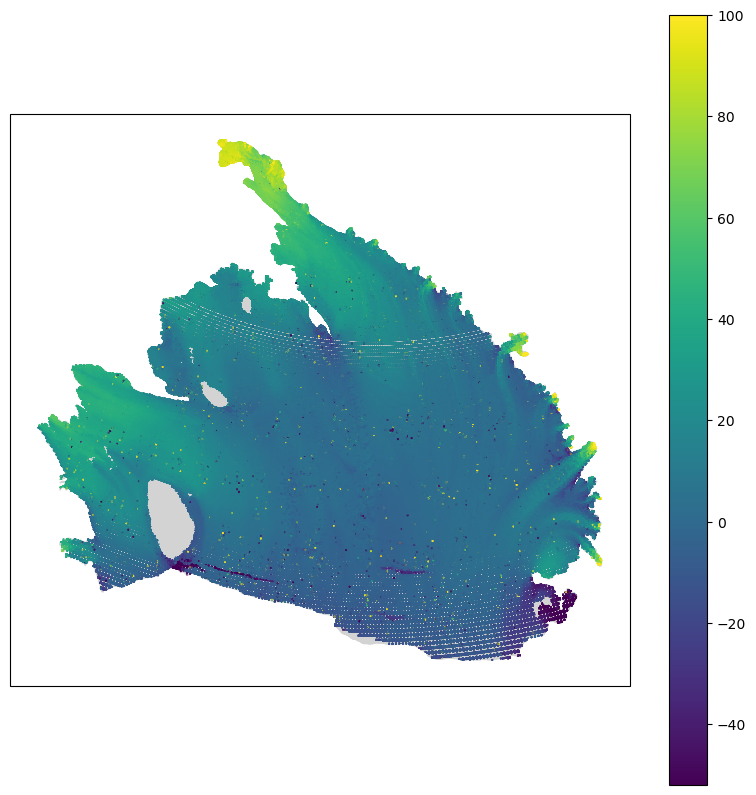

In [12]:

hmin = -52
hmax = 100
# Plot points in mask as sanity check
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ps71_projection},
)
plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "lightgray"], ps71_projection, fill=True)

for one_row_per_lat in one_row_dfs:
    x,y = ll2xy(one_row_per_lat['lon'],one_row_per_lat['lat'])
    print(x,y)
    col = ax.scatter(x,y,s=0.1,zorder=10,c=one_row_per_lat['height_1'],cmap='viridis',vmin=hmin,vmax=hmax)

fig.colorbar(col)

#ax.set_xlim(-600000,-500000)
#ax.set_ylim(-1000000,-900000)

In [27]:
# Laurie only wants crossovers with < 90 days
csv_index = 0
filtered_dfs = []
for df in dfs:
    df['time_1'] = pd.to_datetime(df['time_1'])
    df['time_2'] = pd.to_datetime(df['time_2'])

    time_diff = (df['time_1'] - df['time_2']).abs().dt.days

    filtered_df = df[time_diff < 90]
    print(len(filtered_df))
    filtered_dfs.append(filtered_df)

590406
1455621
825092
1022341
808310
1087083
1168180
983521
921375
787386
1288088
800352
1371033
964093
807058
886643
881167
917940
1387894
1262323
892350
1237441
628803
845141
1054144
1126057
1158698
1050126
480297
694967
1415070
1281601
906671
938781
872784
1071761
616694
800966
819564
1580848
706858
1030930
577767
1031732
784717
646140
1190358
957367
632837
1006775
1240977
378761
795174
1101404
981289
1477125
1296738
869533
1149205
507554


In [28]:
combined_df = pd.concat(filtered_dfs, ignore_index=True)
print("Saving Dataframe")
combined_df.to_csv(f"Ross_ATL11Crossovers.csv", index=False)

Saving Dataframe


In [29]:
len(combined_df)

58051911